## Resultados de clasificación

Presentamos los resultados de clasificación para los modelos analizados

- GPT-3.5
- Cohere/Aya
- Mixtral
- BETO -- modelo finetuneado



In [1]:

%load_ext autoreload
%autoreload 2
import pandas as pd
from glob import glob
pd.options.display.max_colwidth = 1000
#df_train.loc[df_train["LGBTI"] > 0, ["title", "text", "text_label"]].sample(20)

files = {
    #"one-shot": sorted(glob("../data/test*pred*1shot.csv")),
    "gpt-3.5": sorted(glob("../data/runs/test_*_chatgpt.csv")),
    "beto": sorted(glob("../data/runs/test*beto.csv")),
    "aya": sorted(glob("../data/runs/test*aya.csv")),
    "mixtral": sorted(glob("../data/runs/test*mixtral.csv")),
}

#assert len({len(value) for value in files.values()}) == 1

dfs = {k: pd.concat([pd.read_csv(f, index_col=0) for f in v]) for k, v in files.items()}


In [2]:
{k: v.shape for k, v in dfs.items()}

{'gpt-3.5': (5670, 24),
 'beto': (5670, 22),
 'aya': (5670, 25),
 'mixtral': (5670, 25)}

In [3]:
from rioplatense_hs.preprocessing import text_to_label, labels
from sklearn.metrics import classification_report

pred_labels = [f"PRED_{label}" for label in labels]
score_labels = [f"SCORE_{label}" for label in labels]

dfs["beto"][score_labels] = dfs["beto"][pred_labels]
dfs["beto"][pred_labels] = (dfs["beto"][pred_labels] > 0.5).astype(int)

In [4]:
from rioplatense_hs.preprocessing import labels as all_labels
labels = ["WOMEN", "LGBTI", "RACISM", "CLASS"]

pred_labels = [f"PRED_{label}" for label in labels]

all_pred_labels = [f"PRED_{label}" for label in all_labels]

In [5]:
from tqdm.auto import tqdm
from confidence_intervals import Bootstrap
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = []

for name, df in dfs.items():
    print(name)
    for label in tqdm(labels):

        for metric in {"precision", "recall", "f1"}:
            if metric == "precision":
                score = precision_score
            elif metric == "recall":
                score = recall_score
            elif metric == "f1":
                score = f1_score


            gold_labels = df[label].values
            preds = df[f"PRED_{label}"].values

            bst = Bootstrap(metric=score, num_bootstraps=150)

            bst_scores = bst.run(preds, gold_labels)

            for score in bst_scores:
                metrics.append(
                    {
                        "model": name,
                        "label": label,
                        "metric": metric,
                        "score": score,
                    }
                )


gpt-3.5


  0%|          | 0/4 [00:00<?, ?it/s]

beto


  0%|          | 0/4 [00:00<?, ?it/s]

aya


  0%|          | 0/4 [00:00<?, ?it/s]

mixtral


  0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
df_metrics = pd.DataFrame(metrics)

df_metrics

,model,label,metric,score
0,gpt-3.5,WOMEN,f1,0.388571
1,gpt-3.5,WOMEN,f1,0.300341
2,gpt-3.5,WOMEN,f1,0.336770
3,gpt-3.5,WOMEN,f1,0.331126
4,gpt-3.5,WOMEN,f1,0.425532
...,...,...,...,...
7195,mixtral,CLASS,precision,0.107969
7196,mixtral,CLASS,precision,0.092965
7197,mixtral,CLASS,precision,0.123515
7198,mixtral,CLASS,precision,0.075000


In [23]:
pd.options.display.float_format = "{:.4f}".format

pd.options.display.max_rows = 100


def get_metrics_df(metric ):
    metric_df = df_metrics[df_metrics["metric"] == metric]

    del metric_df["metric"]


    mean = metric_df.groupby(["model", "label"]).agg("mean").reset_index().pivot(index="label", columns="model", values="score") * 100
    std = metric_df.groupby(["model", "label"]).agg("std").reset_index().pivot(index="label", columns="model", values="score") * 100

    mean = mean.round(1)
    std = std.round(1)

    # Show as mean +- std (as a string)

    mean = mean.astype(str)
    std = std.astype(str)

    return (mean + " ± " + std).loc[:, ["aya", "mixtral", "gpt-3.5", "beto"]]

get_metrics_df("f1")

model,aya,mixtral,gpt-3.5,beto
label,,,,
CLASS,6.1 ± 0.8,18.9 ± 2.5,30.4 ± 4.0,57.7 ± 5.2
LGBTI,20.9 ± 2.2,45.7 ± 3.9,49.9 ± 4.4,45.7 ± 5.1
RACISM,32.5 ± 1.7,51.6 ± 2.3,55.5 ± 2.5,74.7 ± 2.2
WOMEN,16.7 ± 1.6,29.0 ± 2.3,33.8 ± 3.4,43.0 ± 4.2


In [24]:
get_metrics_df("precision")

model,aya,mixtral,gpt-3.5,beto
label,,,,
CLASS,3.2 ± 0.4,11.3 ± 1.6,22.8 ± 3.4,73.8 ± 6.6
LGBTI,12.1 ± 1.4,33.2 ± 3.4,43.2 ± 4.7,58.8 ± 6.4
RACISM,20.0 ± 1.3,37.3 ± 2.2,46.8 ± 2.8,80.2 ± 2.8
WOMEN,9.7 ± 1.0,18.0 ± 1.7,28.9 ± 3.3,58.2 ± 5.5


In [25]:
get_metrics_df("recall")

model,aya,mixtral,gpt-3.5,beto
label,,,,
CLASS,58.2 ± 5.4,59.5 ± 5.8,46.4 ± 6.1,47.7 ± 5.8
LGBTI,78.7 ± 4.5,73.9 ± 5.4,59.4 ± 5.5,37.6 ± 5.1
RACISM,87.1 ± 2.1,83.9 ± 2.6,68.2 ± 2.9,70.0 ± 2.9
WOMEN,59.4 ± 4.1,74.9 ± 3.7,40.8 ± 4.3,34.2 ± 4.1


Estaría bueno calcular un p-valor en LGBTI para ver si la diferencia es significativa

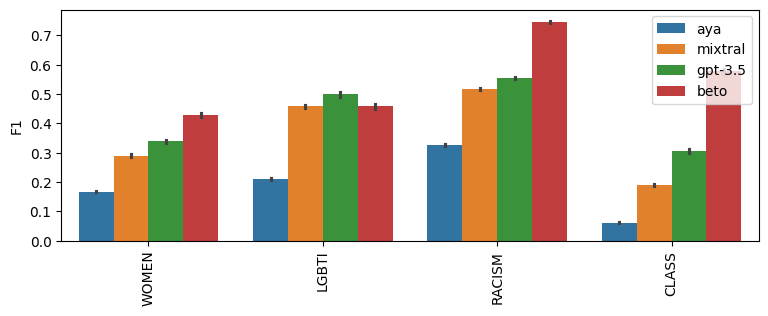

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot


model_order = ["aya", "mixtral", "gpt-3.5", "beto"]

def plot_metric(df, metric, labels, legend=True):
    plt.figure(figsize=(9, 3))

    sub_df = df[(df["metric"] == metric) & (df["label"].isin(labels))]

    sns.barplot(x='label', y='score', hue='model', data=sub_df, hue_order=model_order)


    # Set the plot title and labels
    plt.xlabel('')
    plt.ylabel(metric.capitalize())

    # Show the plot

    # Remove xticks

    #plt.xticks(ticks=[])
    plt.xticks(rotation=90)
    # Make legend smaller
    if legend:
        plt.legend(loc='upper right')#, bbox_to_anchor=(0.35, 1.03))


metric = "f1"
plot_metric(df_metrics, metric, labels)
plt.savefig(f"img/{metric}.png", bbox_inches='tight', dpi=300)

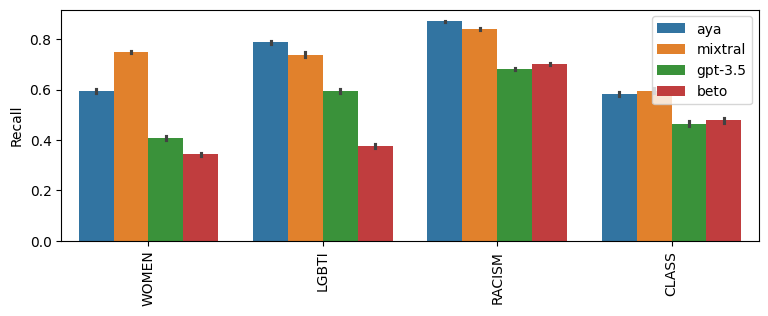

In [27]:
plot_metric(df_metrics, "recall", all_labels)
plt.savefig(f"img/recall.png", bbox_inches='tight', dpi=300)

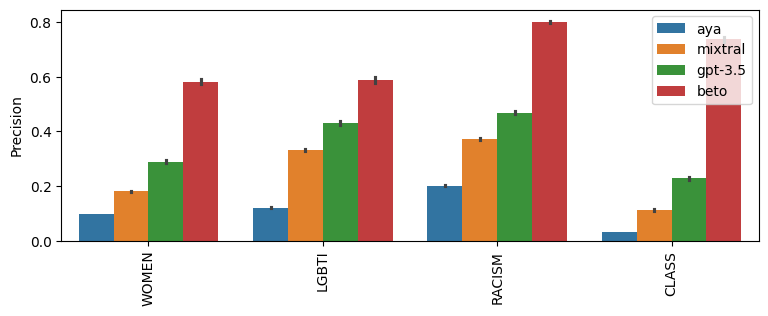

In [28]:
plot_metric(df_metrics, "precision", all_labels)
plt.savefig(f"img/precision.png", bbox_inches='tight', dpi=300)

## Métricas agrupadas

¿Cómo funciona esto si no miramos qué categorías marca un clasificador, sino simplemente binarizamos las salidas?

In [29]:
# Just keep the most important characteristics

hate_metrics = []

# If set to True, uses all labels. If not, only WOMEN, LGBTI, RACISM, CLASS
evaluate_all = False


for name, df in dfs.items():
    if not evaluate_all:
        label_hate = df[labels].sum(axis=1) > 0
        pred_hate = df[pred_labels].sum(axis=1) > 0
    else:
        label_hate = df[all_labels].sum(axis=1) > 0
        pred_hate = df[all_pred_labels].sum(axis=1) > 0
    for metric in {"precision", "recall", "f1"}:
        if metric == "precision":
            score = precision_score
        elif metric == "recall":
            score = recall_score
        elif metric == "f1":
            score = f1_score


        gold_labels = label_hate.values
        preds = pred_hate.values

        bst = Bootstrap(metric=score, num_bootstraps=150)

        bst_scores = bst.run(preds, gold_labels)

        for score in bst_scores:
            hate_metrics.append(
                {
                    "model": name,
                    "metric": metric,
                    "score": score,
                }
            )

hate_metrics = pd.DataFrame(hate_metrics)

hate_metrics

,model,metric,score
0,gpt-3.5,f1,0.4818
1,gpt-3.5,f1,0.4877
2,gpt-3.5,f1,0.4785
3,gpt-3.5,f1,0.4751
4,gpt-3.5,f1,0.5000
...,...,...,...
1795,mixtral,precision,0.2568
1796,mixtral,precision,0.2500
1797,mixtral,precision,0.2680
1798,mixtral,precision,0.2336


([0, 1, 2], [Text(0, 0, 'f1'), Text(1, 0, 'recall'), Text(2, 0, 'precision')])

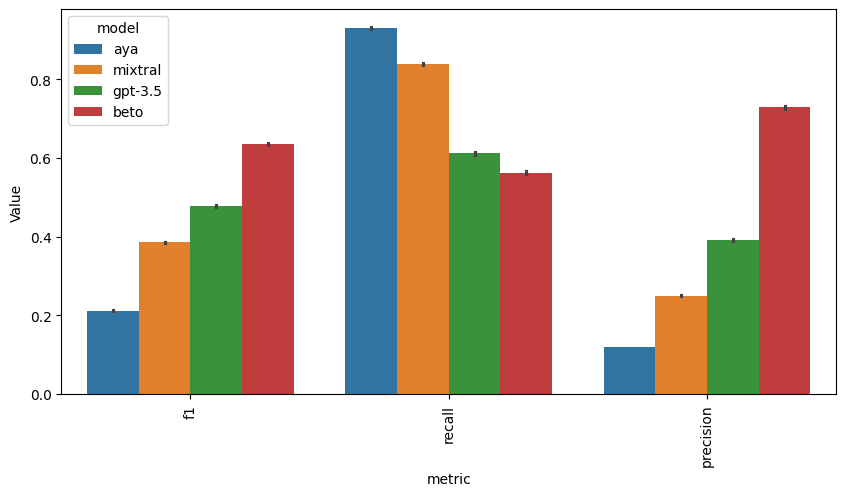

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

plt.figure(figsize=(10, 5))
sns.barplot(x='metric', y='score', hue='model', data=hate_metrics, hue_order=model_order)


plt.ylabel('Value')

# Show the plot

plt.xticks(rotation=90)
#plt.show()

In [34]:

# Show as mean +/- std
metrics_copy = hate_metrics.copy()

metrics_copy["score"] *= 100

res = metrics_copy.groupby(["model", "metric"]).mean().round(1).astype(str) + " +- " + metrics_copy.groupby(["model", "metric"]).std().round(1).astype(str)

# Show as mean +/- std with models as columns

res = res.reset_index().pivot(index="metric", columns="model", values="score")

res.loc[['precision', 'recall', 'f1'], ["aya", "mixtral", "gpt-3.5", "beto"]]

model,aya,mixtral,gpt-3.5,beto
metric,,,,
precision,11.9 +- 0.5,25.1 +- 1.0,39.2 +- 1.8,72.9 +- 2.4
recall,93.0 +- 1.2,83.8 +- 1.7,61.2 +- 2.2,56.3 +- 2.1
f1,21.2 +- 0.8,38.6 +- 1.3,47.8 +- 1.8,63.5 +- 1.8


## LGBTI 

BETO vs few-shot ChatGPT

In [15]:
# Merge dfs['few-shot'] and dfs['beto']

columns_to_drop = [
    "title", "text", "context_tweet", "HATEFUL", "CALLS", "WOMEN", "LGBTI", "RACISM", "CLASS", "POLITICS", "DISABLED", "CRIMINAL", "APPEARANCE",
    "PRED_CALLS", "PRED_POLITICS", "PRED_DISABLED", "PRED_CRIMINAL", "PRED_APPEARANCE",
]



df_join = dfs["gpt-3.5"].join(dfs["beto"].drop(columns_to_drop, axis=1), rsuffix="_beto")

cols = [c for c in df_join.columns if c.isupper() and "SCORE" not in c]

df_join[cols] = df_join[cols].astype(bool)

Ejemplos que falla BETO y acierta ChatGPT y eran LGBTI

In [16]:
df_join.columns

Index(['title', 'text', 'context_tweet', 'HATEFUL', 'CALLS', 'WOMEN', 'LGBTI',
       'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL',
       'prompt', 'pred_cot', 'PRED_WOMEN', 'PRED_LGBTI', 'PRED_RACISM',
       'PRED_CLASS', 'PRED_POLITICS', 'PRED_DISABLED', 'PRED_APPEARANCE',
       'PRED_CRIMINAL', 'PRED_HATEFUL', 'PRED_WOMEN_beto', 'PRED_LGBTI_beto',
       'PRED_RACISM_beto', 'PRED_CLASS_beto', 'SCORE_WOMEN', 'SCORE_LGBTI',
       'SCORE_RACISM', 'SCORE_CLASS', 'SCORE_POLITICS', 'SCORE_DISABLED',
       'SCORE_APPEARANCE', 'SCORE_CRIMINAL'],
      dtype='object')

In [17]:
df_join.loc[df_join["LGBTI"] & df_join["PRED_LGBTI"] & ~df_join["PRED_LGBTI_beto"]][["context_tweet", "text", "pred_cot", "SCORE_LGBTI"]]

,context_tweet,text,pred_cot,SCORE_LGBTI
id,,,,
398914,Mara Gómez: la historia de la primera futbolista trans en el torneo argentino https://t.co/rBx3pMPUbB https://t.co/l5I1j0xFku,"@usuario Ponga huevos, Mara ponga huevos...","El texto alienta a Mara Gómez como futbolista, pero utiliza la expresión ""ponga huevos"" de manera discriminatoria, con el objetivo de cuestionar su masculinidad y su identidad de género como mujer trans. La respuesta final es ""lgbti"".",0.3844
405355,Tras una ráfaga de más de 20 disparos asesinaron a una mujer trans en Rosario https://t.co/M0K3NXgfA8,@usuario En la autopsia no debe figurar la próstata por ley! 😄,"El mensaje hace referencia a la identidad de género de la mujer trans asesinada de manera discriminatoria, utilizando un emoji para burlarse de la situación. La respuesta final es ""lgbti"".",0.0617
359386,Eugenio Zaffaroni: “Con Macri no hubiéramos tenido cuarentena y tendríamos miles de muertos” https://t.co/DhKGcEjTzz https://t.co/0XURGdhX3C,@usuario VOS ZAFARONI HDP CUIDATE Y NO HABLES MAS PUTO DE MIERDA,"El texto contiene insultos homofóbicos hacia Eugenio Zaffaroni (""puto"") y deseo de daño físico (""cuidate y no hables más""). Por lo tanto, el discurso de odio presente es ""lgbti"".",0.0008
382137,"Elizabeth Gómez Alcorta: “Por la pandemia, vamos a tener una suba de los femicidios y travesticidios” | Por Luciana Peker https://t.co/OGEL4INojA",@usuario Trasvescidios? 🤔\n\n Por la cercanía del verano vamos a ver un aumento en la tasa de los mosquicidios,"El texto hace una burla despectiva con el término ""travesticidios"", minimizando la problemática de los crímenes de odio contra personas trans. Aunque no menciona directamente a personas de la comunidad lgbti, la comparación con ""mosquicidios"" es discriminatoria. La respuesta final es ""lgbti"".",0.0007
395663,"Alberto Fernández: ""Me iría a un isla desierta con Máximo Kirchner "" https://t.co/J11MNnD5Yb https://t.co/ALGYab7Xch",@usuario @usuario Si el gordo tiene una pinta de sodomita!JAJA,"El texto utiliza un término despectivo para referirse a la orientación sexual de Máximo Kirchner (""sodomita""), lo cual constituye discurso de odio hacia la comunidad LGBTI. La respuesta final es ""lgbti"".",0.0263
396716,"""Te amo "". La emotiva dedicatoria de Luis Novaresio a su pareja en su cumpleaños https://t.co/Hh63kaVA5U https://t.co/vNaUBjBkzx",@usuario Definitivamente no acepto esta degeneración repugnante de la humanidad.,"El texto expresa un rechazo hacia la relación homosexual de Luis Novaresio, ya que utiliza términos como ""degeneración repugnante"". Por lo tanto, el tweet contiene un discurso de odio hacia la comunidad LGBTI. La respuesta final es ""lgbti"".",0.0653
405366,Tras una ráfaga de más de 20 disparos asesinaron a una mujer trans en Rosario https://t.co/M0K3NXgfA8,@usuario Salió de caño... cuac!,"El texto utiliza un término despectivo (""caño"") para referirse a la forma en que asesinaron a la mujer trans. Aunque no insulta directamente a la mujer trans, la forma en que se refiere a su muerte es despectiva y minimiza la gravedad del crimen. La respuesta final es ""lgbti"".",0.0016
327760,Los infectados en villas porteñas crecieron un 80% en cuatro días https://t.co/8Cc7pgnSzG https://t.co/iOpldGjWAz,"@usuario Ojalá que el virus penetre más en las villas y maten a todos esos delincuentes que viven ahi, hay paraguayos narcos, bolivianos que traen la droga de bolivia, y gente de mala vida. También hay travas que van a trabajar de noche a palermo.","El texto contiene discurso de odio hacia múltiples características protegidas. Primero, el mensaje discrimina a los habitantes de las villas al desear que el virus se propague más en esos lugares y mate a quienes viven ahí, utilizando términos despectivos como ""delincuentes"", ""paraguayos narcos"", ""bolivianos que traen la droga de Bolivia"" y ""gente de mala vida"". Además, se hace referencia de manera discriminatoria hacia las personas trans al mencionar ""travas"" de manera